In [1]:
# https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

# Imports

In [2]:
%reset -f
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.optim import AdamW

from controller import Controller

In [4]:
c = Controller('i01')

device = torch.device('cpu')

# Load data

In [5]:
filepath = fr'{c.get_path_iteration()}/{c.iteration}_ss.pkl'
selection_set = pd.read_pickle(filepath)

In [6]:
filepath = fr'{c.get_path_data_prepared()}/01_df_train_val_test.pkl'
df_train_val_test = pd.read_pickle(filepath)

df_train = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Train"')
print(f'{df_train.shape=}')
df_val = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Validation"')
print(f'{df_val.shape=}')
df_test = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Test"')
print(f'{df_test.shape=}')

df_train_val_test

df_train.shape=(38655, 114)
df_val.shape=(4295, 114)
df_test.shape=(4773, 114)


,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT,EVENT_RISK,EVENT_RISK_STR
0,1574675,201808,0601-1200,SNA.Airport,CA,NaN,NaN,NaN,5000.0,NA,...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,NA,We were cleared for the RNP RNAV Z 20R Approac...,NA,B737-700 flight crew reported failing to make ...,Train,2,Medium risk
1,1224894,201412,0601-1200,MSY.Airport,LA,NaN,NaN,1000.0,NaN,VMC,...,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,NA,NA,NA,Captain reports sighting of a drone at 1;000 f...,Train,0,Low risk
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,NaN,NaN,NaN,2600.0,IMC,...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,NA,NA,NA,SR22 pilot became disoriented on approach in I...,Train,3,Moderately high risk
3,1222074,201411,1201-1800,CWA.Airport,WI,NaN,20.0,NaN,4000.0,NA,...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,NA,NA,NA,BE58 pilot experiences pitot heat failure desc...,Train,2,Medium risk
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,NaN,NaN,NaN,32000.0,NA,...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,NA,NA,NA,B737 First Officer reported unexpected moderat...,Train,3,Moderately high risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,NaN,IMC,...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,NA,[Report narrative contained no additional info...,NA,CRJ-900 flight crew reported being dispatched ...,Test,3,Moderately high risk
47719,1087474,201305,1201-1800,PHX.Airport,AZ,NaN,NaN,NaN,8000.0,VMC,...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,NA,There was an Airbus that departed before us an...,NA,CE750 flight crew departing PHX Runway 25R on ...,Test,3,Moderately high risk
47720,1756601,202008,NA,NA,NA,NaN,NaN,0.0,NaN,NA,...,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,NA,NA,NA,Air carrier First Officer reported that re-qua...,Test,0,Low risk
47721,1102938,201307,0601-1200,MEM.Airport,TN,NaN,NaN,NaN,NaN,VMC,...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,NA,NA,NA,On initial climb out via the GOETZ RNAV SID fr...,Test,2,Medium risk


# Get data for BERT

In [7]:
train_text = df_train['REPORT_1_NARRATIVE']
train_labels = df_train['EVENT_RISK']

val_text = df_val['REPORT_1_NARRATIVE']
val_labels = df_val['EVENT_RISK']

test_text = df_test['REPORT_1_NARRATIVE']
test_labels = df_test['EVENT_RISK']

print(f'{train_text.shape=}')
print(f'{train_labels.shape=}')
print(f'{val_text.shape=}')
print(f'{val_labels.shape=}')
print(f'{test_text.shape=}')
print(f'{test_labels.shape=}')

train_text.shape=(38655,)
train_labels.shape=(38655,)
val_text.shape=(4295,)
val_labels.shape=(4295,)
test_text.shape=(4773,)
test_labels.shape=(4773,)


# Run BERT

## Import model

In [8]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

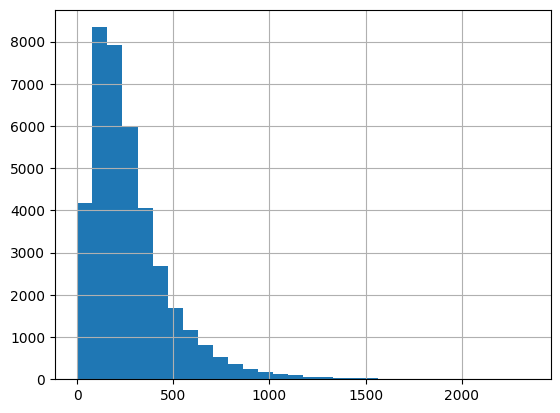

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

## Tokenize & Encode the sequences

In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
print(len(tokens_train['input_ids'][0]))
print(len(tokens_train['input_ids'][1]))
print(len(tokens_train['input_ids'][2]))
print(len(tokens_train['input_ids'][4]))
print(len(tokens_train['input_ids'][6]))

512
512
512
512
512


In [12]:
# convert to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Data Loader

In [13]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Model Architecture

In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [22]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,5)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert).to(device)

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print(f'{class_weights=}')

class_weights=array([0.88770238, 1.65298268, 0.57706949, 1.30349014, 1.30129608])


In [24]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float).to(device)

# define the loss function
cross_entropy = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## Fine Tune

In [25]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [26]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [27]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  1,208.


KeyboardInterrupt: 